In [180]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import shutil
from pathlib import Path

from datetime import datetime

from tempfile import TemporaryDirectory
from tempfile import mkdtemp

import os
import platform
import subprocess
#from shapely.geometry import Polygon, Point
#from scipy.interpolate import make_interp_spline

# Plot Results

In [3]:
model_ws = "C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1027115022_wasaga_c96bgfib" # HMOC
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [185]:
# FDM 70 years
model_ws = 'C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1027155237_wasaga_8w84q7ca' 
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [167]:
model_ws = 'C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1027151129_wasaga_pzvlih61' ## Heterogeneity , Sigma=2
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [186]:
dis = model.dis
nrow = dis.nrow
ncol = dis.ncol
nlay = dis.nlay

delr = 2200/nrow
delc = 2200/ncol
layer_thickness = 30/nlay

nper = model.dis.nper

c:\Users\swan47\Miniconda3\envs\flopy_env\lib\site-packages\flopy\plot\crosssection.py:561: UserWarning: Warning: converting a masked element to nan.
  plotarray = np.array([a[cell] for cell in sorted(self.projpts)])


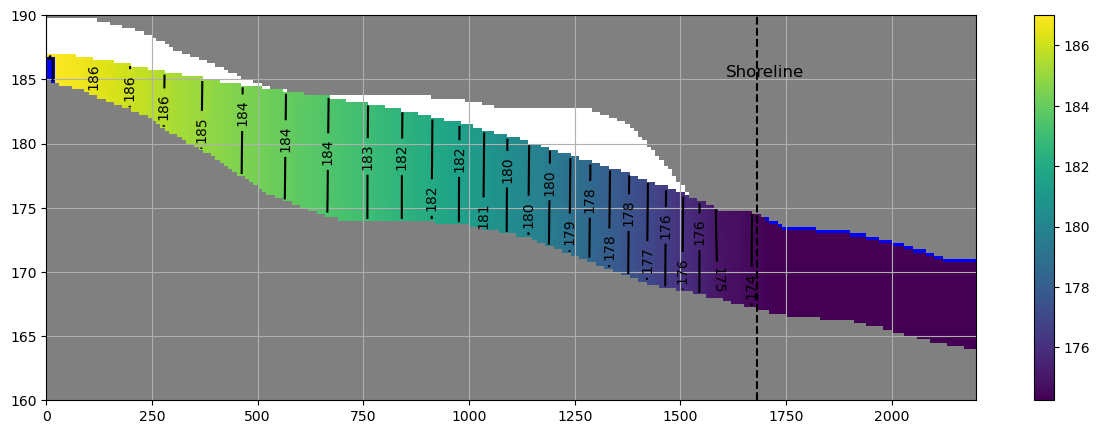

In [187]:
fig = plt.figure(figsize=(15, 5))
xsect = flopy.plot.PlotCrossSection(model=model, line={"Column": 0})

hds = flopy.utils.binaryfile.HeadFile(model_ws + '/example_model.hds')
head_data = hds.get_data(kstpkper=(0, 0)) # (time step, stress period)

ibd = model.bas6.ibound.array
masked_head_data = np.ma.masked_where(ibd== 0, head_data)

cs = xsect.plot_array(masked_head_data, cmap="viridis")
plt.colorbar(cs)

contour_levels = np.arange(164, 188, 0.5)
contour_set = xsect.contour_array(masked_head_data, levels=contour_levels, colors="black")
plt.clabel(contour_set, inline=True, fontsize=10, fmt="%1.0f")
plt.grid()

ibd = xsect.plot_ibound(color_noflow='grey')
#ibd.set_facecolor("red")  # set the color of the masked cells to grey

plt.axvline(x=1680, color='black', linestyle='--')

plt.text(1700, 185, 'Shoreline', ha='center', va='bottom', fontsize=12)
#xs = drn_ys
#ys = [ lay_to_meter(locate_ground_surface_lay(meter_to_row(y))) for y in drn_ys]
#plt.scatter([x - 0.0 for x in xs],[y- 0.0 for y in ys],c='r',marker='s',s=5)

plt.savefig(Path(model_ws)/'_output/hds.png')

In [173]:

### read data

col = int(ncol/3)
ibound = model.bas6.ibound.array

for kper in range(nper):
    # Read the concentration data from the UCN file
    ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001.UCN')
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

    # Mask the inactive cells
    mask = ((ibound== 0)|(concentration_array>=1e30))
    masked_conc_data = np.ma.masked_where(mask, concentration_array)



    ### plotting# ####################

    fig = plt.figure(figsize=(15, 4))

    line = {"Column": col}

    # Create a PlotCrossSection object for the model
    xsect = flopy.plot.PlotCrossSection(model=model, line=line)

    # Plot the concentration results
    cs = xsect.plot_array(masked_conc_data, cmap='coolwarm', vmin=0.1, vmax=1000)
    plt.colorbar(cs)
    ibd = xsect.plot_ibound(color_noflow='grey')
    plt.title('col:{:03}, kper:{:02}'.format(col,kper))
    plt.savefig(Path(model_ws)/'_output/conc_{:02}.png'.format(kper))
    plt.clf()

##------------------------



<Figure size 1500x400 with 0 Axes>

<Figure size 1500x400 with 0 Axes>

<Figure size 1500x400 with 0 Axes>

<Figure size 1500x400 with 0 Axes>

<Figure size 1500x400 with 0 Axes>

<Figure size 1500x400 with 0 Axes>

<Figure size 1500x400 with 0 Axes>

<Figure size 1500x400 with 0 Axes>

<Figure size 1500x400 with 0 Axes>

<Figure size 1500x400 with 0 Axes>

<Figure size 1500x400 with 0 Axes>

<Figure size 1500x400 with 0 Axes>

<Figure size 1500x400 with 0 Axes>

<Figure size 1500x400 with 0 Axes>

<Figure size 1500x400 with 0 Axes>

<Figure size 1500x400 with 0 Axes>

<Figure size 1500x400 with 0 Axes>

<Figure size 1500x400 with 0 Axes>

<Figure size 1500x400 with 0 Axes>

<Figure size 1500x400 with 0 Axes>

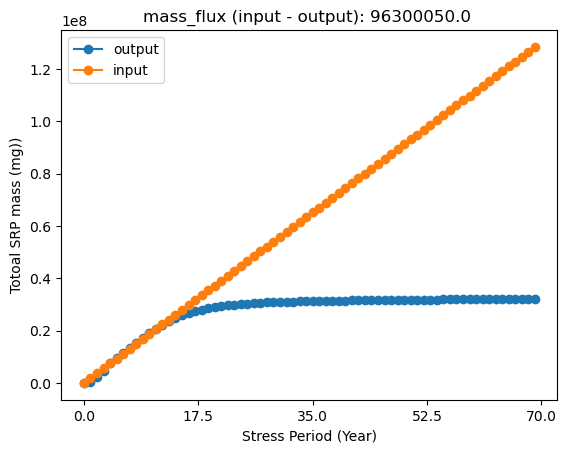

In [199]:
cmass =[]
cmass_in = []
kpers = []
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001.UCN')
for kper in range(nper):

    # Read the concentration data from the UCN file
    if kper==0:
        source_mass = 0
    else:
        source_mass += 365*0.51*5000*2
    
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)
    concentration_array[np.where(concentration_array==1e30)] = 0
    concentration_array[np.where(ibound!=1)] = 0

    csum = concentration_array[np.where(concentration_array>0.11)].sum()
    mass = csum*delr*delc*layer_thickness* 0.25

    cmass_in.append(source_mass)
    cmass.append(mass)
    kpers.append(kper)

ys = cmass
ys2 = cmass_in
xs = kpers



plt.ylabel('Totoal SRP mass (mg))')
#plt.xticks(np.linspace(0,nper,5))
plt.xlabel('Stress Period (Year)')
plt.title('mass_flux (input - output): {} '.format(cmass_in[-1] - cmass[-1]))
plt.plot(xs,ys,marker='o',label='output')
plt.plot(xs,ys2,marker='o',label= 'input')
plt.legend()
plt.savefig(Path(model_ws)/'_output' /'mass.png')

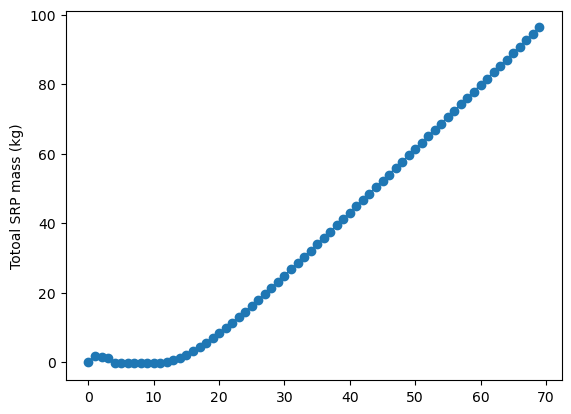

In [205]:
ys= (np.array(cmass_in)-np.array(cmass))/1000/1000
xs = kpers
plt.plot(xs,ys,marker='o')
plt.ylabel('Totoal SRP mass (kg)')
plt.savefig(Path(model_ws)/'_output' /'mass_flux_out.png')

In [204]:
nper = model.dis.nper
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001.UCN')
for kper in range(nper):
    
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))

    temp_array=np.zeros([nrow,ncol])
    for lay in range(nlay):
        layer_conc = concentration_array[lay,:,:]
        mask = np.where(layer_conc!=1e30)

        temp_array[mask] += layer_conc[mask]


    mapview = flopy.plot.PlotMapView(model=model)
    mp = mapview.plot_array(temp_array, cmap='coolwarm', vmin=0, vmax=30000)
    plt.colorbar(mp)
    plt.title('kper:{:02}'.format(kper))

    plt.savefig(Path(model_ws)/'_output'/'map_conc_{:02}'.format(kper))
    
    plt.clf()

<Figure size 640x480 with 0 Axes>

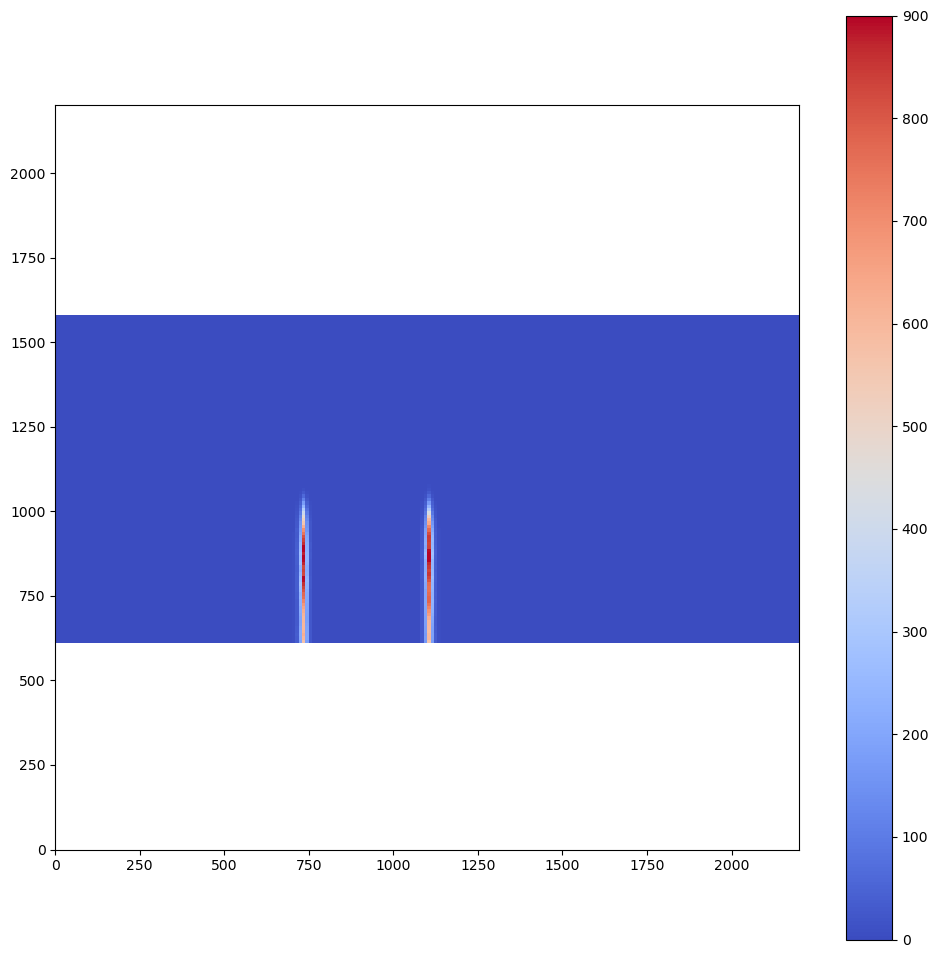

In [140]:
kper = 19
lay = int(nlay/2)

fig = plt.figure(figsize=(15, 5))
mapview = flopy.plot.PlotMapView(model=model, layer=lay)
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001.UCN')
concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

ibound = model.bas6.ibound.array
mask = ((ibound== 0)|(concentration_array>=1e30))
masked_conc_data = np.ma.masked_where(mask, concentration_array)

cs = mapview.plot_array(masked_conc_data, cmap='coolwarm', vmin=0, vmax=900)
plt.colorbar(cs)

# Show the plot
plt.gcf().set_size_inches(12,12)
plt.show()

# Matplotlib 3D

In [206]:
kper = 9
col = int(ncol)/2

# Read the concentration data from the UCN file
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001.UCN')
concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

concentration_array[concentration_array==1e30]=0
#concentration_array[concentration_array<=0.1]=0

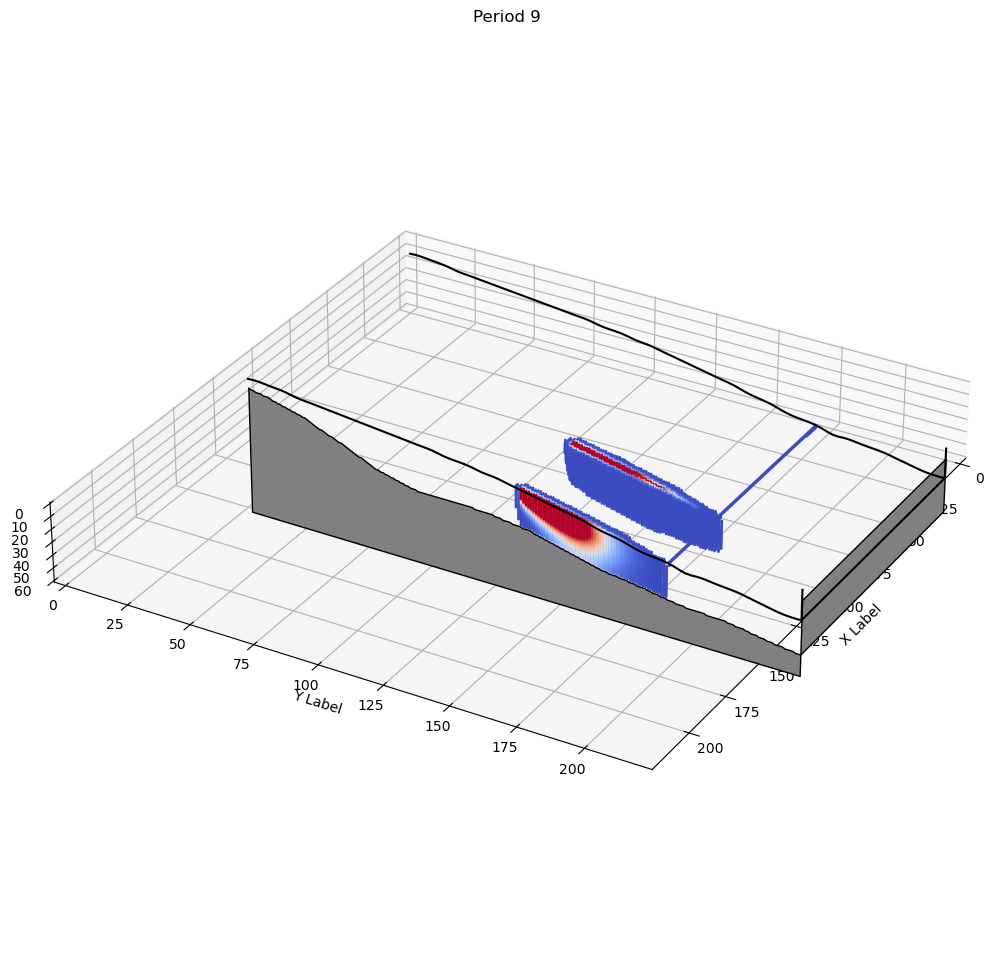

In [209]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


colum = int(ncol/2)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Fixing random state for reproducibility
arr = concentration_array[:,:,:colum]

coords = np.where(arr>0.11)
zs,ys,xs = coords
vs = arr[coords]
ax.scatter(xs, ys, zs, marker='o',s=1,alpha=1,cmap='coolwarm',c=vs,vmax=200)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')



ibd = model.bas6.ibound.array[:,:,0]
zs = np.array([np.where(col!=0)[0][-1]for col in ibd.T])
ys = np.arange(len(zs))
zs = list(zs) + [nlay,nlay]
ys = list(ys) + [ys[-1],0]
xs = np.repeat(colum,len(ys))

verts = [list(zip(xs, ys, zs))]
poly = Poly3DCollection(verts)
poly.set_facecolor('grey')
poly.set_edgecolor('black')
ax.add_collection3d(poly)


ibd = model.bas6.ibound.array[:,:,0]
z1 = np.array([np.where(col!=0)[0][-1]for col in ibd.T])[-1]
zs = [z1,z1,60,60]
ys = [nrow-1,nrow-1,nrow-1,nrow-1]
xs = [colum, 0,  0,colum]

verts = [list(zip(xs, ys, zs))]
poly = Poly3DCollection(verts)
poly.set_facecolor('grey')
poly.set_edgecolor('black')
ax.add_collection3d(poly)



xs = list(wt)
ys =list(np.arange(0,len(xs)))

xs = xs[::5] +xs[-1:]
ys  = ys[::5] +ys[-1:]

spline = make_interp_spline(ys, xs)
ys_smooth = np.linspace(min(ys), max(ys), 100)
xs_smooth = spline(ys_smooth)
zs_smooth = np.repeat(colum,len(xs_smooth))
ax.plot(zs_smooth,ys_smooth,xs_smooth,c='k',zorder=10)

xs = [zs_smooth[-1],zs_smooth[-1]]
ys = [ys_smooth[-1],ys_smooth[-1]]
zs = [xs_smooth[-1],52]
ax.plot(xs,ys,zs,c='k',zorder=10)

xs = [0,zs_smooth[-1]]
ys = [ys_smooth[-1],ys_smooth[-1]]
zs = [xs_smooth[-1],xs_smooth[-1]]
ax.plot(xs,ys,zs,c='k',zorder=10)


zs_smooth = np.repeat(0,len(xs_smooth))
ax.plot(zs_smooth,ys_smooth,xs_smooth,c='k',zorder=10)

xs = [zs_smooth[-1],zs_smooth[-1]]
ys = [ys_smooth[-1],ys_smooth[-1]]
zs = [xs_smooth[-1],52]
ax.plot(xs,ys,zs,c='k',zorder=10)



ax.set_xlim(0,220)
ax.set_ylim(0,220)
ax.set_zlim(0,60)
ax.view_init(elev=30, azim=30)
ax.set_box_aspect((2200,2200,30*10))
ax.invert_zaxis()


fig.set_size_inches(12,12)

plt.title('Period {}'.format(kper))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

for kper in range(0,20):



    # Read the concentration data from the UCN file
    ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001.UCN')
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))# 
    concentration_array[concentration_array==1e30]=0

    colum = int(ncol/2)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # Fixing random state for reproducibility
    arr = concentration_array[:,:,:colum]

    coords = np.where(arr>0)
    zs,ys,xs = coords
    vs = arr[coords]
    ax.scatter(xs, ys, zs, marker='o',s=1,alpha=1,cmap='coolwarm',c=vs,vmax=200)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')



    ibd = model.bas6.ibound.array[:,:,0]
    zs = np.array([np.where(col!=0)[0][-1]for col in ibd.T])
    ys = np.arange(len(zs))
    zs = list(zs) + [nlay,nlay]
    ys = list(ys) + [ys[-1],0]
    xs = np.repeat(colum,len(ys))

    verts = [list(zip(xs, ys, zs))]
    poly = Poly3DCollection(verts)
    poly.set_facecolor('grey')
    poly.set_edgecolor('black')
    ax.add_collection3d(poly)


    ibd = model.bas6.ibound.array[:,:,0]
    z1 = np.array([np.where(col!=0)[0][-1]for col in ibd.T])[-1]
    zs = [z1,z1,60,60]
    ys = [nrow-1,nrow-1,nrow-1,nrow-1]
    xs = [colum, 0,  0,colum]

    verts = [list(zip(xs, ys, zs))]
    poly = Poly3DCollection(verts)
    poly.set_facecolor('grey')
    poly.set_edgecolor('black')
    ax.add_collection3d(poly)



    xs = list(wt)
    ys =list(np.arange(0,len(xs)))

    xs = xs[::5] +xs[-1:]
    ys  = ys[::5] +ys[-1:]

    spline = make_interp_spline(ys, xs)
    ys_smooth = np.linspace(min(ys), max(ys), 100)
    xs_smooth = spline(ys_smooth)
    zs_smooth = np.repeat(colum,len(xs_smooth))
    ax.plot(zs_smooth,ys_smooth,xs_smooth,c='k',zorder=10)

    xs = [zs_smooth[-1],zs_smooth[-1]]
    ys = [ys_smooth[-1],ys_smooth[-1]]
    zs = [xs_smooth[-1],52]
    ax.plot(xs,ys,zs,c='k',zorder=10)

    xs = [0,zs_smooth[-1]]
    ys = [ys_smooth[-1],ys_smooth[-1]]
    zs = [xs_smooth[-1],xs_smooth[-1]]
    ax.plot(xs,ys,zs,c='k',zorder=10)

    zs_smooth = np.repeat(0,len(xs_smooth))
    ax.plot(zs_smooth,ys_smooth,xs_smooth,c='k',zorder=10)

    xs = [zs_smooth[-1],zs_smooth[-1]]
    ys = [ys_smooth[-1],ys_smooth[-1]]
    zs = [xs_smooth[-1],52]
    ax.plot(xs,ys,zs,c='k',zorder=10)

    ax.set_xlim(0,220)
    ax.set_ylim(0,220)
    ax.set_zlim(0,60)
    ax.view_init(elev=30, azim=30)
    ax.set_box_aspect((2200,2200,30*10))
    ax.invert_zaxis()

    fig.set_size_inches(12,12)
    #plt.show()
    plt.savefig(Path(model_ws) /'_output'/'{0:02d}.png'.format(kper))



from PIL import Image
import os

# Set the directory containing the PNG files
png_dir = Path(model_ws) /'_output'

# Set the output file name
gif_file = 'output.gif'

# Set the size of the resized images
size = (1000, 1000)

# Create a list of all PNG files in the directory
png_files = [f for f in os.listdir(png_dir) if f.endswith('.png')]

# Open each PNG file, resize it, and append it to a list of frames
frames = []
for png_file in png_files:
    with Image.open(os.path.join(png_dir, png_file)) as im:
        im_resized = im.resize(size)
        frames.append(im_resized)

# Save the frames as an animated GIF
frames[0].save(Path(model_ws) /'_output'/ gif_file, save_all=True, append_images=frames[1:], duration=200, loop=0)


# PyVista

In [210]:
import numpy as np
import pyvista as pv
np.bool = np.bool_

c:\Users\swan47\Miniconda3\envs\flopy_env\lib\site-packages\pyvista\jupyter\notebook.py:33: UserWarning: Failed to use notebook backend: 

Your build of VTK does not have the proper web modules enabled.
These modules are typically enabled by default with the
`-DVTK_GROUP_ENABLE_Web:STRING=WANT` build flag.

Conda users: This is a known issue with the conda-forge VTK feedstock.
See https://github.com/conda-forge/vtk-feedstock/pull/258


Falling back to a static output.
  warnings.warn(


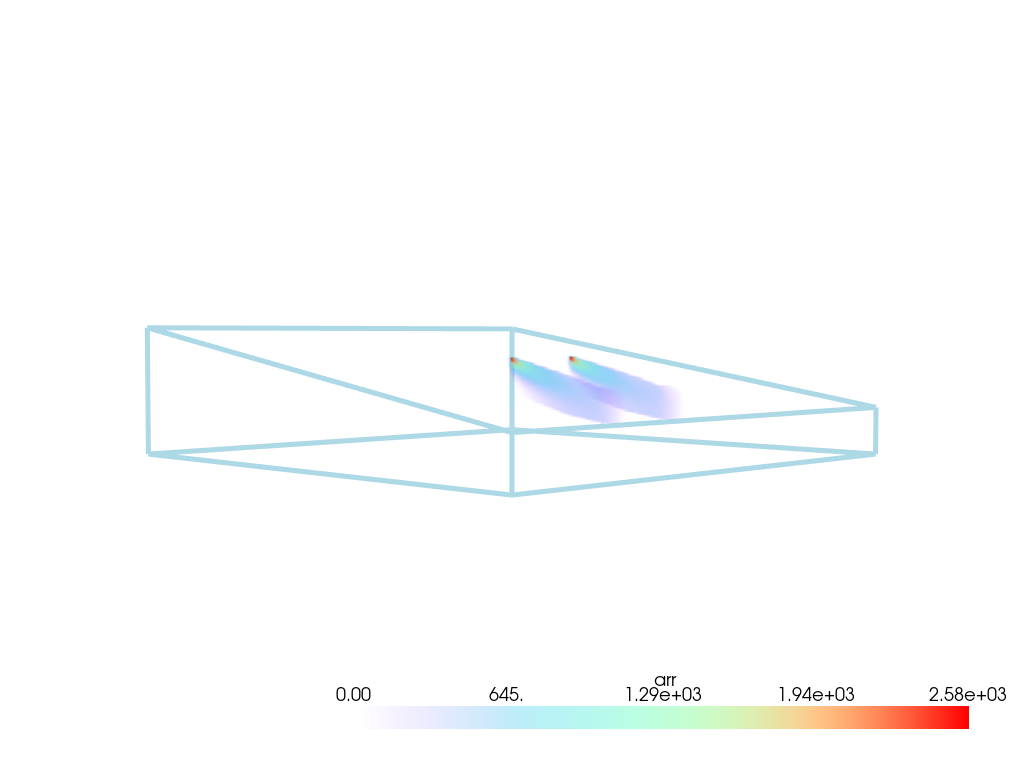

In [409]:

for kper in range(18,19):
    # Read the concentration data from the UCN file
    ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001.UCN')
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

    concentration_array[concentration_array==1e30]=0
    concentration_array[concentration_array<0.1]=0
    arr = concentration_array[:,:,:].T
    arr = arr[:,:,::-1]
    #arr[np.where(arr<1)]=1

    # Create the spatial reference
    grid = pv.ImageData()
    grid.dimensions = np.array(arr.shape) + 1
    grid.origin = (0,0,0)  # The bottom left corner of the data set
    grid.spacing = (delc, delr, 30/nlay)  # These are the cell sizes along each axis


    # Add the data values to the cell data
    grid.cell_data["arr"] = arr.flatten(order="F")  # Flatten the array


    pl = pv.Plotter()
    pl.add_volume(grid,cmap='rainbow')

    points = np.array([[0, 0, 0], [0,0,27],[0,2200,10],[0,2200,0],[0,0,0]])
    poly = pyvista.lines_from_points(points)
    pl.add_mesh(poly, color='lightblue', line_width=5)

    points = np.array([[0,2200,10],[0,2200,0],[2200,2200,0],[2200,2200,10],[0,2200,10]])
    poly = pyvista.lines_from_points(points)
    pl.add_mesh(poly, color='lightblue', line_width=5)


    points = np.array([[2200, 0, 0], [2200,0,27],[2200,2200,10],[2200,2200,0],[2200,0,0]])
    poly = pyvista.lines_from_points(points)
    pl.add_mesh(poly, color='lightblue', line_width=5)


    points = np.array([[0,0,27],[0,0,0],[2200,0,0],[2200,0,27],[0,0,27]])
    poly = pyvista.lines_from_points(points)
    pl.add_mesh(poly, color='lightblue', line_width=5)


    #cpos = [(20, 10, 0), (0,0, 0), (0., 0, 0)] #Lcamera position, focal point, and view up.
    pl.camera_position = 'xy'
    pl.set_scale(zscale=20)

    pl.view_isometric()
    pl.show(screenshot=Path(model_ws)/'_output'/'pv_{:02}'.format(kper))

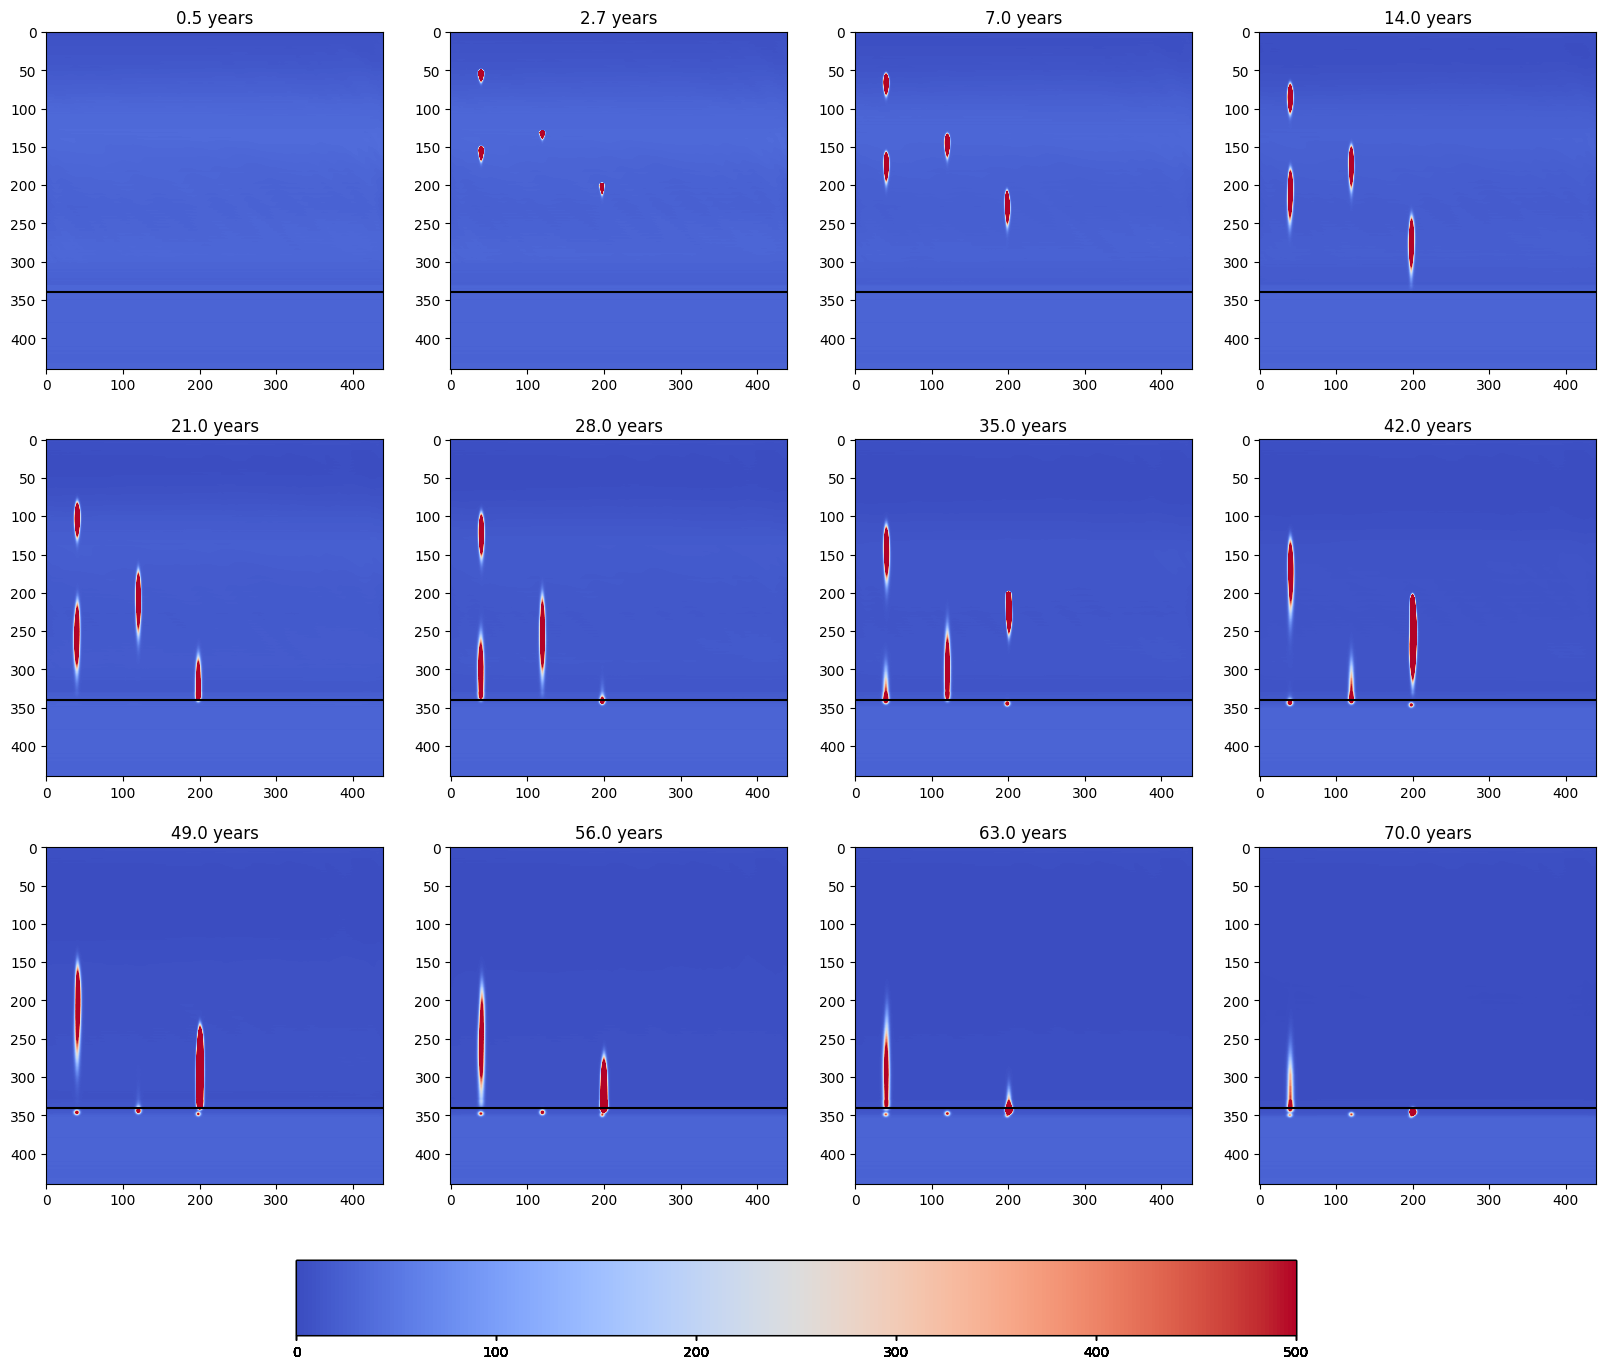

In [511]:
# Create a figure with 2 rows and 4 columns of subplots
fig, axes = plt.subplots(3, 4)

# Load the concentration data from the UCN file
budobj = bf.UcnFile(model_ws + '/MT3D001.UCN', model=model)

# Get the times for which concentration data is available
times = budobj.get_times()

# Select 8 time indices evenly spaced throughout the simulation period
selected_indices = [int(n) for n in np.linspace(0, len(times)-1,12)]

# Loop over the selected time indices
for n in range(12):
    # Get the concentration data for the selected time
    conc = budobj.get_data(totim=times[selected_indices[n]])
    conc[conc==1.e+30] = 0
    
    # Flatten the axes array and select the nth subplot
    ax = axes.flatten()[n]
    
    # Plot the sum of the concentration data over the x-axis
    im1 = ax.imshow(np.sum(conc, axis=0), cmap='coolwarm', vmin=0, vmax=500)
    
    # Add a colorbar to the figure
    cbar_ax = fig.add_axes([0.25, 0.01, 0.5, 0.05])
    fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
    
    # Set the title of the subplot to the selected time in years
    ax.set_title('{:.1f} years'.format(times[selected_indices[n]]/365))
    
    # Add a shoreline  to the subplot
    ax.axhline(y=170*2, c='k')

# Set the size of the figure
fig.set_size_inches(20, 15)

In [ ]:
# Create a figure with 2 rows and 4 columns of subplots
fig, axes = plt.subplots(2, 4)

# Load the concentration data from the UCN file
budobj = bf.UcnFile(model_ws + '/MT3D001.UCN', model=model)

# Get the times for which concentration data is available
times = budobj.get_times()

# Select 8 time indices evenly spaced throughout the simulation period
selected_indices = [int(n) for n in np.linspace(0, len(times)-1,8)]

# Loop over the selected time indices
for n in range(8):
    # Get the concentration data for the selected time
    conc = budobj.get_data(totim=times[selected_indices[n]])
    conc[conc==1.e+30] = 0
    
    # Flatten the axes array and select the nth subplot
    ax = axes.flatten()[n]
    
    # Plot the sum of the concentration data over the x-axis
    im1 = ax.imshow(np.sum(conc, axis=0), cmap='coolwarm', vmin=0, vmax=500)
    
    # Add a colorbar to the figure
    cbar_ax = fig.add_axes([0.25, 0.01, 0.5, 0.05])
    fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
    
    # Set the title of the subplot to the selected time in years
    ax.set_title('{:.1f} years'.format(times[selected_indices[n]]/365))
    
    # Add a shoreline  to the subplot
    ax.axhline(y=140, c='k')

# Set the size of the figure
fig.set_size_inches(20, 8)

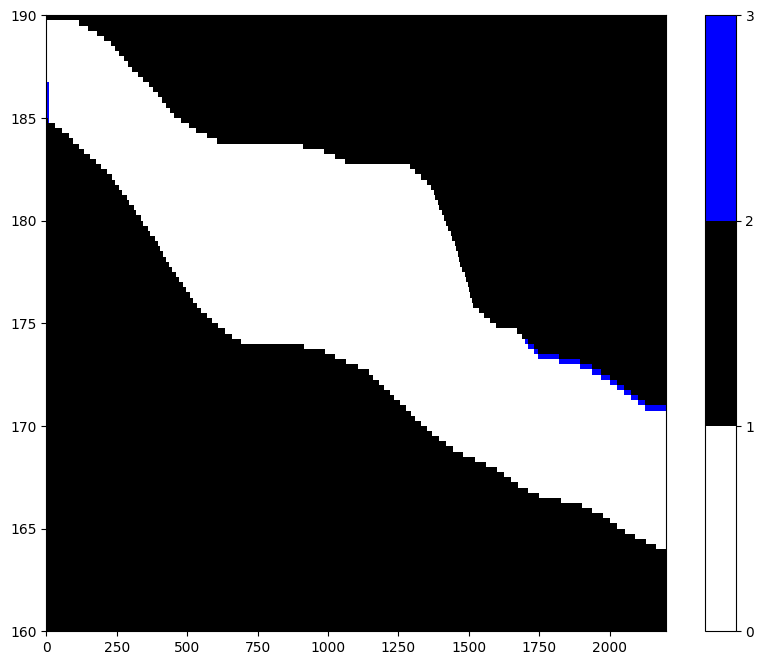

In [ ]:
xsect = flopy.plot.crosssection.PlotCrossSection(model=model, line={'Column': 100})
patches = xsect.plot_ibound()
plt.colorbar(patches)
plt.gcf().set_size_inches(10,8)

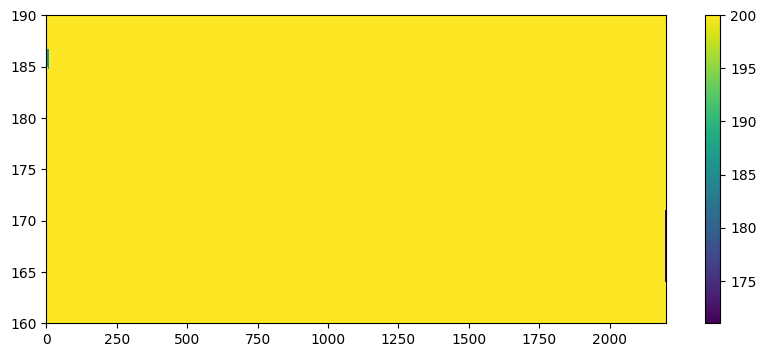

In [ ]:
xsect = flopy.plot.crosssection.PlotCrossSection(model=model, line={'Column': 100})
patches = xsect.plot_array(bas.strt.array)
plt.colorbar(patches)
plt.gcf().set_size_inches(10,4)